In [1]:
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116
!pip install --upgrade pandas
!pip install --upgrade torchsummary

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu116
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Requirement already up-to-date: pandas in /usr/local/lib/python3.8/dist-packages (1.5.3)
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Requirement already up-to-date: torchsummary in /usr/local/lib/python3.8/dist-packages (1.5.1)
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import numpy as np
import random
import os
import time
import matplotlib.pyplot as plt

from ResNet import Bottleneck, ResNet, ResNet50, ResNet18, ResNet34, ResNet101, ResNet152
from torch.utils.data import Dataset
from torch.utils.data.dataset import random_split
from torchvision import models
from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
def mix_random(col, row, mdsm_body):
    size_suffle = random.randint(0,10)
    switchsource = torch.randint(0, row - 1, (size_suffle,))
    temp = np.zeros((1, col), np.float32)
    
    for i in range(0, int(size_suffle)):
        if i == switchsource[i]:
            continue
        temp = mdsm_body[i, :].copy()
        mdsm_body[i, :] = mdsm_body[switchsource[i], :].copy()
        mdsm_body[switchsource[i], :] = temp.copy()
    return torch.tensor(mdsm_body)

def flip_random(col, row, mdsm_body):
    size_suffle = random.randint(0,10)
    if size_suffle % 2 == 0:
        return torch.tensor(mdsm_body)
    
    int_row = int(row)
    for i in range(0, int(int_row / 2)):
        temp = mdsm_body[i, :].copy()
        mdsm_body[i, :] = mdsm_body[int_row - i - 1, :].copy()
        mdsm_body[int_row - i - 1, :] = temp.copy()
    return torch.tensor(mdsm_body)
    
class MDSMDataset(Dataset):
    def __init__(self, mdsmdata_file):
        self.df = pd.read_csv(mdsmdata_file)
        rating = self.df[['ReviewID', 'reviewStar']]
        self.rating = rating.drop_duplicates('ReviewID')
        self.height = self.df['ReviewID'].value_counts().max()

        mdsm_body = self.df.drop(['reviewNo', 'reviewStar'], axis=1)
        mdsm_body['imageCnt'] = (mdsm_body['imageCnt'] - mdsm_body['imageCnt'].min())/ (mdsm_body['imageCnt'].max() - mdsm_body['imageCnt'].min())
        mdsm_body['helpfulCnt'] = (mdsm_body['helpfulCnt'] - mdsm_body['helpfulCnt'].mean())/ mdsm_body['helpfulCnt'].std()
        body_height, body_width = mdsm_body.shape;
        self.width = body_width - 1

        dummy_mdsd = np.zeros((body_height, self.height, self.width), np.float32)
        mdsm_index = np.zeros(self.rating['ReviewID'].max()+1, int)
        mdsm_count = np.zeros(self.rating['ReviewID'].max()+1, int)
        mdsm_index.fill(-1)

        max_index = int(0)
        for index, body in mdsm_body.iterrows():
            dummy_index = max_index
            if mdsm_index[int(body['ReviewID'])] != -1:
                dummy_index = mdsm_index[int(body['ReviewID'])]
            else:
                mdsm_index[int(body['ReviewID'])] = dummy_index
                max_index = max_index + 1

            dummy_mdsd[dummy_index, mdsm_count[dummy_index]] = body.drop('ReviewID')
            mdsm_count[dummy_index] = mdsm_count[dummy_index] + 1

        self.mdsm_body = dummy_mdsd
            
    def __len__(self):
        return self.rating.shape[0]

    
    def __getitem__(self, idx):
        if trans_stat == True:
            #_tensor = flip_random(self.width, self.height, self.mdsm_body[idx])
            #_tensor = mix_random(self.width, self.height, self.mdsm_body[idx])
            _tensor = torch.tensor(self.mdsm_body[idx])
        else:
            _tensor = torch.tensor(self.mdsm_body[idx])
        rtn_tensor = _tensor.unsqueeze(0)
        return rtn_tensor, self.rating.iloc[idx, 1]

In [4]:
print('-- Loading dataset--')

#dataset = MDSMDataset('amazon_hmdvr_df_tokenized_sentiment_score_extended.csv')
dataset = MDSMDataset('amazon_hmdvr_df_tokenized_sentiment_score_extended_normalized.csv')
train_size = round(len(dataset) * 0.9)
test_size = len(dataset) - train_size
print(train_size, ":", test_size)

print('-- Building train and test dataset / dataloader--')
train_dataset, test_dataset = random_split(dataset, [int(train_size),int(test_size)])

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size = 2048, shuffle=True, num_workers=0)
#trainloader = torch.utils.data.DataLoader(dataset, batch_size = 256, shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size = 2048, shuffle=True, num_workers=0)

classes = ['0', '1', '2', '3', '4', '5']

#net = ResNet50(6, 1).to('cuda')
model = ResNet18(6, 1).to('cuda')
#model = ResNet34(6, 1).to('cuda')

summary(model, (1, 108, 12))


-- Loading dataset--
14836 : 1649
-- Building train and test dataset / dataloader--
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 64, 54, 6]           3,136
       BatchNorm2d-2            [-1, 64, 54, 6]             128
              ReLU-3            [-1, 64, 54, 6]               0
         MaxPool2d-4            [-1, 64, 27, 3]               0
            Conv2d-5            [-1, 64, 27, 3]          36,864
       BatchNorm2d-6            [-1, 64, 27, 3]             128
            Conv2d-7            [-1, 64, 27, 3]          36,864
       BatchNorm2d-8            [-1, 64, 27, 3]             128
        BasicBlock-9            [-1, 64, 27, 3]               0
           Conv2d-10            [-1, 64, 27, 3]          36,864
      BatchNorm2d-11            [-1, 64, 27, 3]             128
           Conv2d-12            [-1, 64, 27, 3]          36,864
      BatchNorm2d-1

In [5]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

#loss_func = nn.CrossEntropyLoss(reduction='sum')
#opt = optim.Adam(model.parameters(), lr=0.001)

loss_func = nn.CrossEntropyLoss()
#loss_func = nn.MSELoss()
opt = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001) 
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, factor = 0.1, patience=5)

#lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=10)
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']
    # function to calculate metric per mini-batch
def metric_batch(output, target):
    pred = output.argmax(1, keepdim=True)
    corrects = pred.eq(target.view_as(pred)).sum().item()
    return corrects


# function to calculate loss per mini-batch
def loss_batch(loss_func, output, target, opt=None):
    loss = loss_func(output, target)
    metric_b = metric_batch(output, target)

    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
    running_loss = 0.0
    running_metric = 0.0
    retrived_mse = 0.0
    len_data = len(dataset_dl.dataset)
    loop_count = 0

    for xb, yb in dataset_dl:
        xb = xb.to(device)
        yb = yb.to(device)
        output = model(xb)
        
        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)
        #loss_b, metric_b = loss_batch(loss_func, predicted, yb, opt)
        
        mse_loss = nn.MSELoss()
        _, predicted = torch.max(output.data, 1)
        
        yb = yb.type(torch.FloatTensor).to(device)
        predicted = predicted.type(torch.FloatTensor).to(device)
        
        retrived_mse_ = mse_loss(yb, predicted).item()
        retrived_mse += retrived_mse_
        loop_count += 1
        #print(retrived_mse_, retrived_mse)
        
        #print(retrived_mse)
        #retrived_mse.backward()
        
        running_loss += loss_b
        
        if metric_b is not None:
            running_metric += metric_b
        
        if sanity_check is True:
            break

    loss = running_loss / len_data
    metric = running_metric / len_data
    mse = retrived_mse / loop_count

    return loss, metric, mse

# function to start training
def train_val(model, params):
    num_epochs=params['num_epochs']
    loss_func=params["loss_func"]
    opt=params["optimizer"]
    train_dl=params["train_dl"]
    val_dl=params["val_dl"]
    sanity_check=params["sanity_check"]
    lr_scheduler=params["lr_scheduler"]
    path2weights=params["path2weights"]

    loss_history = {'train': [], 'val': []}
    metric_history = {'train': [], 'val': []}
    mse_history = {'train': [], 'val': []}

    # # GPU out of memoty error
    # best_model_wts = copy.deepcopy(model.state_dict())

    best_loss = float('inf')

    start_time = time.time()

    for epoch in range(num_epochs):
        current_lr = get_lr(opt)
        #current_lr = 0.1
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs-1, current_lr))

        model.train()
        train_loss, train_metric, mse = loss_epoch(model, loss_func, train_dl, sanity_check, opt)
        loss_history['train'].append(train_loss)
        metric_history['train'].append(train_metric)
        mse_history['train'].append(mse)
        #print(mse)
        #print("eval")
        model.eval()
        with torch.no_grad():
            val_loss, val_metric, mse = loss_epoch(model, loss_func, val_dl, sanity_check)
        loss_history['val'].append(val_loss)
        metric_history['val'].append(val_metric)
        mse_history['val'].append(mse)
        
        if val_loss < best_loss:
            best_loss = val_loss
            # best_model_wts = copy.deepcopy(model.state_dict())

            # torch.save(model.state_dict(), path2weights)
            # print('Copied best model weights!')
            print('Get best val_loss')

        lr_scheduler.step(val_loss)

        print('train loss: %.6f, val loss: %.6f, accuracy: %.2f, time: %.4f min' %(train_loss, val_loss, 100*val_metric, (time.time()-start_time)/60))
        print('-'*10)

    # model.load_state_dict(best_model_wts)

    return model, loss_history, metric_history, mse_history

# definc the training parameters
params_train = {
    'num_epochs':200,
    'optimizer':opt,
    'loss_func':loss_func,
    'train_dl':trainloader,
    'val_dl':testloader,
    'sanity_check':False,
    'lr_scheduler':lr_scheduler,
    'path2weights':'./models/weights.pt',
}

# create the directory that stores weights.pt
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSerror:
        print('Error')
createFolder('./models')



In [6]:
trans_stat = True
model, loss_hist, metric_hist, mse_hist = train_val(model, params_train)

Epoch 0/199, current lr=0.1
Get best val_loss
train loss: 0.000945, val loss: 0.000864, accuracy: 56.46, time: 0.0132 min
----------
Epoch 1/199, current lr=0.1
train loss: 0.000743, val loss: 0.003124, accuracy: 57.37, time: 0.0253 min
----------
Epoch 2/199, current lr=0.1
train loss: 0.000634, val loss: 0.001025, accuracy: 54.94, time: 0.0370 min
----------
Epoch 3/199, current lr=0.1
Get best val_loss
train loss: 0.000630, val loss: 0.000686, accuracy: 60.40, time: 0.0491 min
----------
Epoch 4/199, current lr=0.1
Get best val_loss
train loss: 0.000599, val loss: 0.000666, accuracy: 61.31, time: 0.0612 min
----------
Epoch 5/199, current lr=0.1
Get best val_loss
train loss: 0.000604, val loss: 0.000663, accuracy: 62.22, time: 0.0728 min
----------
Epoch 6/199, current lr=0.1
train loss: 0.000596, val loss: 0.000667, accuracy: 61.73, time: 0.0849 min
----------
Epoch 7/199, current lr=0.1
Get best val_loss
train loss: 0.000601, val loss: 0.000651, accuracy: 62.10, time: 0.0965 min
-

train loss: 0.000543, val loss: 0.000641, accuracy: 61.86, time: 0.7527 min
----------
Epoch 63/199, current lr=1.0000000000000005e-08
train loss: 0.000545, val loss: 0.000641, accuracy: 61.92, time: 0.7649 min
----------
Epoch 64/199, current lr=1.0000000000000005e-08
train loss: 0.000541, val loss: 0.000641, accuracy: 62.04, time: 0.7765 min
----------
Epoch 65/199, current lr=1.0000000000000005e-08
train loss: 0.000544, val loss: 0.000641, accuracy: 62.04, time: 0.7887 min
----------
Epoch 66/199, current lr=1.0000000000000005e-08
train loss: 0.000549, val loss: 0.000641, accuracy: 62.04, time: 0.8009 min
----------
Epoch 67/199, current lr=1.0000000000000005e-08
train loss: 0.000545, val loss: 0.000641, accuracy: 61.92, time: 0.8125 min
----------
Epoch 68/199, current lr=1.0000000000000005e-08
train loss: 0.000548, val loss: 0.000641, accuracy: 62.04, time: 0.8247 min
----------
Epoch 69/199, current lr=1.0000000000000005e-08
train loss: 0.000547, val loss: 0.000641, accuracy: 61.

train loss: 0.000544, val loss: 0.000641, accuracy: 61.92, time: 1.4817 min
----------
Epoch 124/199, current lr=1.0000000000000005e-08
train loss: 0.000544, val loss: 0.000641, accuracy: 61.92, time: 1.4938 min
----------
Epoch 125/199, current lr=1.0000000000000005e-08
train loss: 0.000548, val loss: 0.000641, accuracy: 62.04, time: 1.5055 min
----------
Epoch 126/199, current lr=1.0000000000000005e-08
train loss: 0.000543, val loss: 0.000641, accuracy: 62.04, time: 1.5176 min
----------
Epoch 127/199, current lr=1.0000000000000005e-08
train loss: 0.000546, val loss: 0.000641, accuracy: 61.92, time: 1.5294 min
----------
Epoch 128/199, current lr=1.0000000000000005e-08
train loss: 0.000542, val loss: 0.000641, accuracy: 61.73, time: 1.5415 min
----------
Epoch 129/199, current lr=1.0000000000000005e-08
train loss: 0.000545, val loss: 0.000641, accuracy: 61.80, time: 1.5536 min
----------
Epoch 130/199, current lr=1.0000000000000005e-08
train loss: 0.000546, val loss: 0.000641, accura

train loss: 0.000543, val loss: 0.000641, accuracy: 61.98, time: 2.2107 min
----------
Epoch 185/199, current lr=1.0000000000000005e-08
train loss: 0.000545, val loss: 0.000641, accuracy: 62.04, time: 2.2228 min
----------
Epoch 186/199, current lr=1.0000000000000005e-08
train loss: 0.000551, val loss: 0.000641, accuracy: 62.04, time: 2.2345 min
----------
Epoch 187/199, current lr=1.0000000000000005e-08
train loss: 0.000546, val loss: 0.000641, accuracy: 62.04, time: 2.2467 min
----------
Epoch 188/199, current lr=1.0000000000000005e-08
train loss: 0.000547, val loss: 0.000641, accuracy: 61.98, time: 2.2583 min
----------
Epoch 189/199, current lr=1.0000000000000005e-08
train loss: 0.000547, val loss: 0.000642, accuracy: 61.98, time: 2.2704 min
----------
Epoch 190/199, current lr=1.0000000000000005e-08
train loss: 0.000546, val loss: 0.000641, accuracy: 61.92, time: 2.2821 min
----------
Epoch 191/199, current lr=1.0000000000000005e-08
train loss: 0.000547, val loss: 0.000641, accura

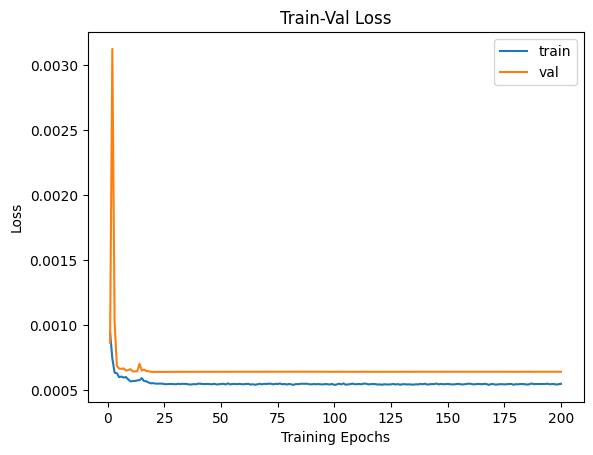

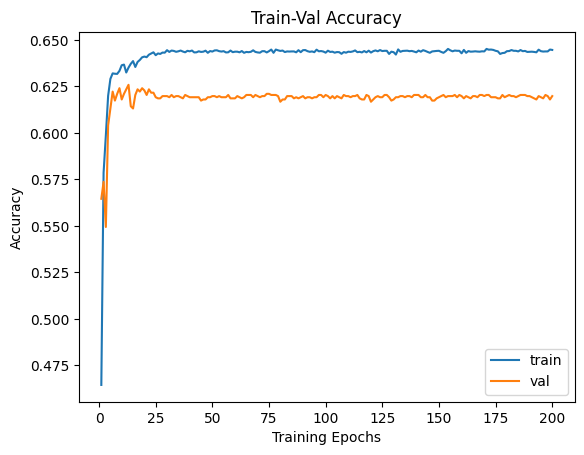

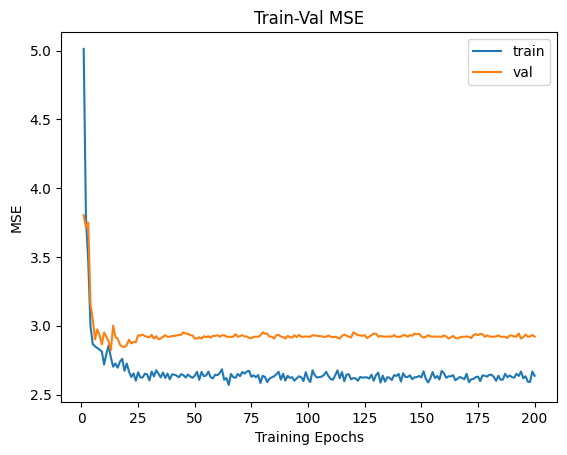

In [7]:
# Train-Validation Progress
num_epochs=params_train["num_epochs"]

# plot loss progress
plt.title("Train-Val Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot accuracy progress
plt.title("Train-Val Accuracy")
plt.plot(range(1,num_epochs+1),metric_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),metric_hist["val"],label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot accuracy progress
plt.title("Train-Val MSE")
plt.plot(range(1,num_epochs+1),mse_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),mse_hist["val"],label="val")
plt.ylabel("MSE")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()